In [125]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [126]:
df_1 = pd.read_csv("C:\\Users\\tjmcp\\Personal Projects\\Datasets\\titanic\\train.csv")
df_2 = pd.read_csv("C:\\Users\\tjmcp\\Personal Projects\\Datasets\\titanic\\test.csv")

# add survival column to the train dataframs then combine train and test dataframes
df_2['Survived'] = 0
df = pd.concat([df_1, df_2], axis = 0 )
df.head()
df = df.drop(['Name','Ticket','Cabin'],axis =1)

#change categorical values to nmerical
df['Sex'] = df['Sex'].map({'male': 0, 'female':1})
df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

<Axes: >

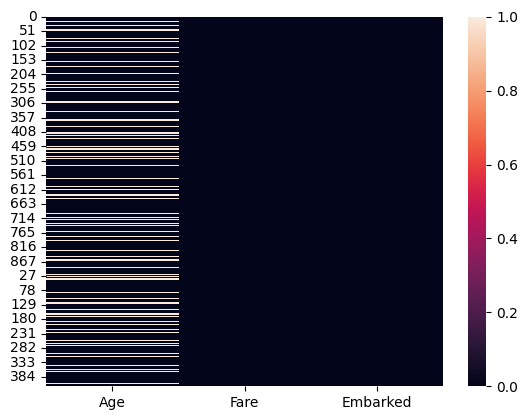

In [127]:
#takes columns with at least 1 null value
df_null = df[df.isnull().sum()[df.isnull().sum() >0].index]
#use heatmap to visualize which values have the most null values
sns.heatmap(df_null.isnull())

In [128]:
# #make dataframe with only data of type object
# df_objects = df[df.select_dtypes(include=['object']).columns]

# #drop columns with too many null values
# df = df.drop(df[df_objects.isna().sum()[df_objects.isna().sum()>600].index], axis = 1)
# df_objects = df_objects.drop(df_objects[df_objects.isna().sum()[df_objects.isna().sum()>600].index], axis = 1)

# #replace nan with null
# df_objects = df_objects.fillna('null')

# #encode the objects
# df_objects_encoded = pd.get_dummies(df_objects)

# df.head()
# df_objects_encoded.head()

In [129]:
# # drop all columns containing null and print which were dropped 
# for i in df_objects_encoded.columns:
#     if 'null' in i:
#         df_objects_encoded = df_objects_encoded.drop(i, axis =1)
#         print(i)

In [130]:
# #create new df from old df and encoded objects
# new_df = pd.concat([df, df_objects_encoded],axis = 1)

# #drop all objects columns since the encoded df has already translated them
# new_df = new_df.drop(new_df.select_dtypes(include= ['object']),axis=1)

# #print count of all nan values
# new_df.isna().sum()[new_df.isna().sum() >0]

In [131]:
#fill nan in age column with median 
df['Age'] = df['Age'].fillna(np.round(df['Age'].median())) 
#fill nan in embarked and fare column with mode
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Fare'] = df['Fare'].fillna(df['Fare'].mode()[0]) 

#check that all nan were filled in 
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

In [132]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,2.0
1,2,1,1,1,38.0,1,0,71.2833,0.0
2,3,1,3,1,26.0,0,0,7.9250,2.0
3,4,1,1,1,35.0,1,0,53.1000,2.0
4,5,0,3,0,35.0,0,0,8.0500,2.0


In [133]:
#split new_df in to test and train using length of df_1
training_data = df[0: len(df_1)]
testing_data = df[len(df_1):]

#drop survived column 
testing_data = testing_data.drop(columns = 'Survived')

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

In [135]:
#split training data into X and y
X = training_data.drop(columns= 'Survived')
y = training_data['Survived']

#split data into training and testing sets 80/20 split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size= .2)

#reshape the target variables into target vectors
Y_train = np.reshape(Y_train, (-1,1)) # Reshaping for a single feature target
Y_test = np.reshape(Y_test,(-1,1))


#check shap of x and y train
X_train.shape, Y_train.shape

X_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
466,467,2,0,28.00,0,0,0.0000,2.0
831,832,2,0,0.83,1,1,18.7500,2.0
460,461,1,0,48.00,0,0,26.5500,2.0
699,700,3,0,42.00,0,0,7.6500,2.0
111,112,3,1,14.50,1,0,14.4542,0.0


In [136]:
## Testing different prediction methods to see which is best

In [137]:
#Linear Regression
linreg_model = LinearRegression()
linreg_model.fit(X,y)
y_pred = linreg_model.predict(X_test)

#find mean squared error between the predicted values and the true values
mean_squared_error(Y_test, y_pred)

0.13924255905275473

In [138]:
#XGBRegressor
xgb_model = XGBRegressor(n_estimators = 1000, learning_rate = .1)
xgb_model.fit(X,y)
y_pred = xgb_model.predict(X_test)

mean_squared_error(Y_test, y_pred)

1.7652142560109496e-05

In [139]:
#Random Forest
randomforest_model = RandomForestRegressor(n_estimators=100)
randomforest_model.fit(X, y)
y_pred = randomforest_model.predict(X_test)

mean_squared_error(Y_test,y_pred)

0.01633519553072626

In [140]:
pred = randomforest_model.predict(testing_data)

final = pd.DataFrame()
final['PassengerId'] = testing_data[['PassengerId']]
final['Survived'] = np.round(pred)

#Write DataFrame to CSV file without index
final.to_csv('output.csv', index = False)
final.describe()

,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.322967
std,120.810458,0.468170
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


In [141]:
# # Select features
# features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# X_test = testing_data[features]
# # Make predictions
# predictions = randomforest_model.predict(X_test)
# # Create submission file
# submission = pd.DataFrame({
#     'PassengerId': testing_data['PassengerId'],
#     'Survived': predictions
# })
# submission.to_csv('submission.csv', index=False)
# print("Submission file saved as 'submission.csv'.")